In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as tfkl
from IPython.display import Audio
import soundfile as sf
import glob
from dummy_data import generate_dummy_data

2022-05-07 18:51:58.248203: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


# Dummy data

In [56]:
audio_list = glob.glob('/mnt/datasets/clean_voice/dev-clean/**/*.flac', recursive=True)
data_x, data_y = generate_dummy_data(audio_list, 10000)

100%|███████████████████████████| 10000/10000 [08:24<00:00, 19.80it/s]


# Modelo
Primero recreo lo que dice el paper (o lo que parece que dice)

In [57]:
"""
Modo de la convolucion? padding same? valid?

Maxpoolings con stride=1? Se contradice en el parrafo del paper

Ojo con donde ponemos el batch norm, que por cierto no esta en la tablita

Mandar mail, puede servir
"""

tf.keras.backend.clear_session()

audio_in = tfkl.Input((200,1), name='Audio de entrada')

capa_1 = tfkl.Conv1D(filters=32, kernel_size=(10), activation='relu', name='capa1_conv')(audio_in)
capa_1 = tfkl.MaxPool1D(pool_size=2, strides=1, name='capa1_pool')(capa_1)
capa_1 = tfkl.BatchNormalization(name = 'Batch_capa1')(capa_1)

capa_2 = tfkl.Conv1D(filters=16, kernel_size=(5), activation='relu', name='capa2_conv')(capa_1) 
capa_2 = tfkl.MaxPool1D(pool_size=2, strides=1, name='capa2_pool')(capa_2)
capa_2 = tfkl.Dropout(0.4, name='capa2_drop')(capa_2)

capa_3 = tfkl.Conv1D(filters=8, kernel_size=(5), activation='relu', name='capa3_conv')(capa_2) 
capa_3 = tfkl.MaxPool1D(pool_size=2, name='capa3_pool')(capa_3)

capa_4 = tfkl.Conv1D(filters=4, kernel_size=(5), activation='relu', name='capa4_conv')(capa_3)
capa_4 = tfkl.Flatten()(capa_4)
tr_pred = tfkl.Dense(1, name='Salida_prediccion')(capa_4) # solo calculo tr

modelo = tf.keras.Model(inputs=[audio_in], outputs=[tr_pred])
modelo.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

In [58]:
modelo.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Audio de entrada (InputLayer [(None, 200, 1)]          0         
_________________________________________________________________
capa1_conv (Conv1D)          (None, 191, 32)           352       
_________________________________________________________________
capa1_pool (MaxPooling1D)    (None, 190, 32)           0         
_________________________________________________________________
Batch_capa1 (BatchNormalizat (None, 190, 32)           128       
_________________________________________________________________
capa2_conv (Conv1D)          (None, 186, 16)           2576      
_________________________________________________________________
capa2_pool (MaxPooling1D)    (None, 185, 16)           0         
_________________________________________________________________
capa2_drop (Dropout)         (None, 185, 16)           0     

Ahora hago uno como probaria yo

In [82]:
def modelo_martin():
    tf.keras.backend.clear_session()

    audio_in = tfkl.Input((200,1), name = 'Audio de entrada')

    capa_1 = tfkl.Conv1D(filters=32, kernel_size=(10), activation='relu', name='capa1_conv')(audio_in)
    capa_1 = tfkl.MaxPool1D(pool_size=2, name='capa1_pool')(capa_1)
    capa_1 = tfkl.BatchNormalization(name = 'Batch_capa1')(capa_1)

    capa_2 = tfkl.Conv1D(filters=16, kernel_size=(5), activation='relu', name='capa2_conv')(capa_1) 
    capa_2 = tfkl.MaxPool1D(pool_size=2, name='capa2_pool')(capa_2)
    capa_2 = tfkl.BatchNormalization(name = 'Batch_capa2')(capa_2)
    capa_2 = tfkl.Dropout(0.4, name='capa2_drop')(capa_2)

    capa_3 = tfkl.Conv1D(filters=8, kernel_size=(5), activation='relu', name='capa3_conv')(capa_2) 
    capa_3 = tfkl.MaxPool1D(pool_size=2, name='capa3_pool')(capa_3)
    capa_3 = tfkl.BatchNormalization(name = 'Batch_capa3')(capa_3)
    
    capa_4 = tfkl.Conv1D(filters=4, kernel_size=(5), activation='relu', name='capa4_conv')(capa_3)
    capa_4 = tfkl.Flatten()(capa_4)
    tr_pred = tfkl.Dense(1, name='Salida_prediccion')(capa_4) # solo calculo tr

    modelo = tf.keras.Model(inputs=[audio_in], outputs=[tr_pred])
    modelo.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    return modelo
modelo_mio = modelo_martin()

In [83]:
modelo_mio.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Audio de entrada (InputLayer [(None, 200, 1)]          0         
_________________________________________________________________
capa1_conv (Conv1D)          (None, 191, 32)           352       
_________________________________________________________________
capa1_pool (MaxPooling1D)    (None, 95, 32)            0         
_________________________________________________________________
Batch_capa1 (BatchNormalizat (None, 95, 32)            128       
_________________________________________________________________
capa2_conv (Conv1D)          (None, 91, 16)            2576      
_________________________________________________________________
capa2_pool (MaxPooling1D)    (None, 45, 16)            0         
_________________________________________________________________
Batch_capa2 (BatchNormalizat (None, 45, 16)            64    

In [8]:
modelo_mio.predict(np.random.rand(200).reshape(1,-1,1), 1)

2022-05-07 19:12:05.991382: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-07 19:12:06.010034: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3199980000 Hz
2022-05-07 19:12:06.188657: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-05-07 19:12:06.464722: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8202
2022-05-07 19:12:06.654134: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-07 19:12:06.654157: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2022-05-07 19:12:06.654785: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-07 19:12:06.654847: W tensorflow/stream_executor/gpu/redzone_allocator.cc:31

array([[-0.04217694]], dtype=float32)

# Entrenando

In [89]:
history = modelo.fit(x=data_x, y=data_y,  validation_split=0.2,  batch_size=512, epochs=100)

Epoch 1/100
16/16 [==============================] - 1s 42ms/step - loss: 0.0039 - val_loss: 0.0340
Epoch 2/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0038 - val_loss: 0.0334
Epoch 3/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0037 - val_loss: 0.0381
Epoch 4/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0037 - val_loss: 0.0342
Epoch 5/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0039 - val_loss: 0.0354
Epoch 6/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0041 - val_loss: 0.0344
Epoch 7/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0038 - val_loss: 0.0318
Epoch 8/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0038 - val_loss: 0.0295
Epoch 9/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0038 - val_loss: 0.0333
Epoch 10/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0039 - val_loss: 0.0347

16/16 [==============================] - 0s 16ms/step - loss: 0.0034 - val_loss: 0.0409
Epoch 83/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0034 - val_loss: 0.0377
Epoch 84/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0035 - val_loss: 0.0605
Epoch 85/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0042 - val_loss: 0.0338
Epoch 86/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0038 - val_loss: 0.0357
Epoch 87/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0040 - val_loss: 0.0502
Epoch 88/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0040 - val_loss: 0.0331
Epoch 89/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0038 - val_loss: 0.0292
Epoch 90/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0040 - val_loss: 0.0490
Epoch 91/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0038 - val_loss: 0.0333
Epo

In [86]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

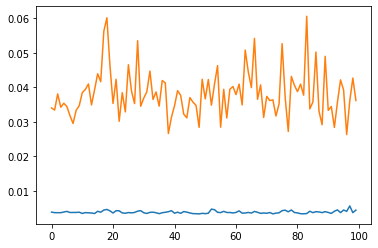

In [90]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [95]:
modelo.predict(data_x[65,:,0].reshape(1,-1,1))

array([[2.1727934]], dtype=float32)

In [96]:
data_y[65]

1.9999999999999996

In [102]:
modelo_mio.fit(x=data_x, y=data_y, batch_size=4096, epochs=100)

Epoch 1/100
3/3 [==============================] - 1s 40ms/step - loss: 0.0225
Epoch 2/100
3/3 [==============================] - 0s 40ms/step - loss: 0.0221
Epoch 3/100
3/3 [==============================] - 0s 41ms/step - loss: 0.0215
Epoch 4/100
3/3 [==============================] - 0s 42ms/step - loss: 0.0215
Epoch 5/100
3/3 [==============================] - 0s 42ms/step - loss: 0.0221
Epoch 6/100
3/3 [==============================] - 0s 41ms/step - loss: 0.0223
Epoch 7/100
3/3 [==============================] - 0s 40ms/step - loss: 0.0221
Epoch 8/100
3/3 [==============================] - 0s 42ms/step - loss: 0.0224
Epoch 9/100
3/3 [==============================] - 0s 42ms/step - loss: 0.0222
Epoch 10/100
3/3 [==============================] - 0s 44ms/step - loss: 0.0223
Epoch 11/100
3/3 [==============================] - 0s 42ms/step - loss: 0.0219
Epoch 12/100
3/3 [==============================] - 0s 42ms/step - loss: 0.0224
Epoch 13/100
3/3 [==============================]

In [103]:
modelo_mio.predict(data_x[119,:,0].reshape(1,-1,1))

array([[0.5720079]], dtype=float32)

In [104]:
data_y[119]

0.5